In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.feature_selection import r_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from matplotlib import pyplot as plt

# Q3

### How are class labels distributed?

In [2]:
#load data

raw_data_labeled = pd.read_csv('task_2_annotations_labeled.csv')
aggregated_data_labeled = pd.read_csv('task_2_annotaions_aggregated_labels.csv')


#load low level dataset
features = pd.read_csv('data_features.csv')

In [3]:
raw_data_labeled.head()

,pianist_id,segment_id,annotator_id,arousal,valence,gems_wonder,gems_transcendence,gems_tenderness,gems_nostalgia,gems_peacefulness,gems_power,gems_joyful_activation,gems_tension,gems_sadness,gemmes_flow,gemmes_movement,gemmes_force,gemmes_interior,gemmes_wandering,label
0,1.0,0.0,91.0,1.0,-1.0,2.0,1.0,2.0,4.0,2.0,1.0,1.0,1.0,2.0,3.0,2.0,1.0,1.0,2.0,sad
1,1.0,0.0,19.0,2.0,-1.0,3.0,3.0,3.0,4.0,4.0,1.0,2.0,3.0,3.0,3.0,2.0,2.0,3.0,3.0,sad
2,1.0,0.0,189.0,2.0,0.0,2.0,1.0,2.0,1.0,4.0,2.0,2.0,1.0,1.0,3.0,2.0,1.0,1.0,4.0,sad
3,1.0,0.0,126.0,2.0,2.0,4.0,5.0,2.0,3.0,5.0,2.0,4.0,1.0,3.0,5.0,1.0,2.0,2.0,5.0,relaxed
4,1.0,0.0,26.0,4.0,2.0,3.0,5.0,2.0,3.0,3.0,1.0,3.0,4.0,1.0,4.0,1.0,2.0,3.0,1.0,happy


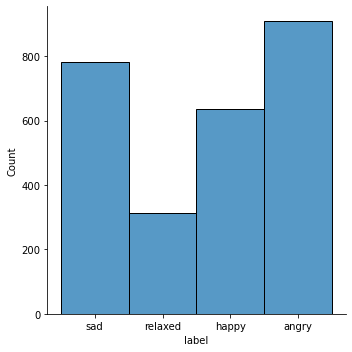

In [5]:
sns.displot(data=raw_data_labeled, x="label")

### Are the classes imbalanced? How much?
We use the entropy to determine how imbalanced the classes are. To get a balance measure between 0 and 1, with 1 being perfectly balanced and 0  being totally unbalanced (i.e. only 1 of k classes in data) we divide the entropy by log k.
Since entropy is 0 if there is only one class and log k if the classes are equally distributed, we divide the entropy by log k, to get 0 for a totally unbalanced dataset (1 class) and 1 for a totally balanced dataset. 

In [4]:
labels = raw_data_labeled['label']

In [5]:
def balance(data, k=2): #k = number of different classes
    
    if k == 1:
        raise ValueError('k must be >= 2')
        
    count_per_class = data.value_counts()
    n = len(labels)
    
    H = 0
    
    for c_i in count_per_class:
        H += c_i/n * np.log(c_i/n)
        
    balance = -H/np.log(k)
    return balance

In [6]:
balance(labels, k=4)

0.954494698684711

### How are the features distributed?

# xxxxxxx TODO! xxxxxxx

In [7]:
#calculate skewnewss
skewness = features.iloc[: , 3:].skew()
skewness.mean()

0.9219011525813766

On average the features are positively skewed.

In [8]:
kurtosis = features.iloc[:, 3:].kurtosis(axis=0)
kurtosis.mean()

8.815145485412256

Kurtosis for nomral dist.: 3
Excess kurtosis = kurtosis - 3 = 8.8

Hence, on average the features are very heavily distributed on the tails. However this assumes that the data is unimodal. There might be multimodal features, but we did not find an easy way to check if all or most features are unimodal.

### Are there any pairs or subsets of features that seem highly correlated or redundant?

In [22]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5, ascending=False):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=ascending)
    return au_corr[0:n]

#### Covar and top correlation pairs

In [26]:
#calculate covariance matrix for features
features_cov = features.iloc[: , 3:].corr() # remove snipped_id etc..
print("Top Absolute Correlations")
df_corr = get_top_abs_correlations(features_cov, 36, ascending=False)
for item in df_corr:
    print(item)

Top Absolute Correlations
0.9999627391702848
0.9999277564133885
0.9998609757139191
0.9998113854092672
0.9997632213895172
0.9997262313304656
0.9995906920739214
0.9995381996233217
0.9995207471049895
0.9993018563218029
0.9988725370460214
0.9986881380272206
0.9986255807219878
0.9983620523731223
0.9982078172452449
0.9977402119874785
0.9977081067595064
0.99722838592533
0.99657279297563
0.9965651918094747
0.9965520941690046
0.9963711832662367
0.9958705140034859
0.9958605668735122
0.9934116798316204
0.991685606011292
0.991409803250066
0.9912509784568848
0.9904886084232272
0.9904691187157246
0.9904211291842493
0.9903658773546129
0.9902882131965195
0.9901799637053494
0.9901508771238524
0.9901064631203895


In [13]:
def magnify():
    return [dict(selector="th",
                 props=[("font-size", "4pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

In [14]:
print(features_cov.shape)

(169, 169)


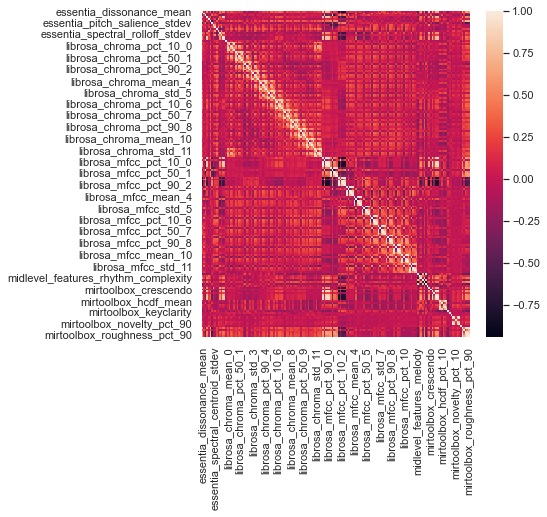

In [15]:
# features_cov.style.background_gradient(cmap='coolwarm').set_properties(**{'font-size': '0pt', 'max-width': '4px'})
sns.set(rc={'figure.figsize':(6,6)})
sns.heatmap(features_cov)
plt.show()

1) 36 feature pairs have a covariance of higher than 0.99

2) 237 feature pairs have a covariance of higher than 0.9

In [16]:
#add labels to snippets in features dataframe
for i, el in aggregated_data_labeled.iterrows():
    features.loc[features['segment_id'] == i, 'label'] = el['label']          

# Q5

### Which features seem useful for classification?


#### Feature importance with random forest

In [22]:
X = features.drop(['pianist_id', 'segment_id', 'snippet_id', 'label'], axis=1)
y = features['label']

le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)

In [23]:
#create split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [24]:
#train random forest
rf = RandomForestRegressor(n_estimators=150)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=150)

In [25]:
sort = rf.feature_importances_.argsort()

C:\Users\hause\AppData\Local\Temp\ipykernel_14684\4104966772.py:4: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.yticks([])


Text(0, 0.5, 'features')

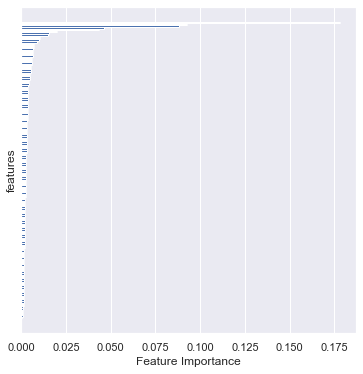

In [26]:
plt.barh(X.columns[sort], rf.feature_importances_[sort])
plt.rcParams["figure.figsize"] = (10,3)

plt.yticks([])
plt.xlabel("Feature Importance")
plt.ylabel('features')


We used a random forest to determine feature importance. On the chart above we can see that most features are not important for classification, and only a hand full are very important.

Let's take a closer look at the most important features.

Text(0.5, 0, 'Feature Importance')

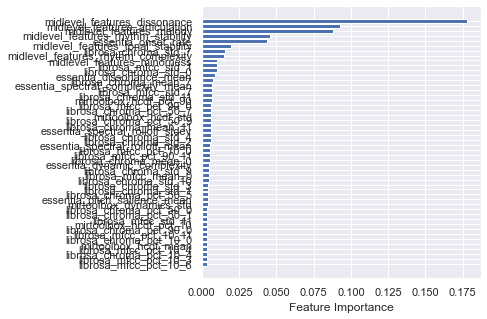

In [31]:
plt.barh(X.columns[sort][-50:], rf.feature_importances_[sort][-50:])

plt.rcParams["figure.figsize"] = (5,5)
plt.xlabel("Feature Importance")


In [32]:
X.columns[sort]

Index(['mirtoolbox_novelty_pct_10', 'librosa_mfcc_mean_8',
       'librosa_mfcc_mean_2', 'librosa_chroma_pct_90_5', 'librosa_mfcc_mean_9',
       'librosa_mfcc_pct_50_7', 'librosa_mfcc_pct_50_8', 'librosa_mfcc_std_6',
       'librosa_chroma_pct_90_6', 'librosa_mfcc_pct_50_0',
       ...
       'librosa_mfcc_std_1', 'midlevel_features_minorness',
       'midlevel_features_rhythm_complexity', 'librosa_chroma_std_7',
       'midlevel_features_tonal_stability', 'essentia_onset_rate',
       'midlevel_features_rhythm_stability', 'midlevel_features_melody',
       'midlevel_features_articulation', 'midlevel_features_dissonance'],
      dtype='object', length=169)

### Which features are correlated with the labels?

In [28]:
features.head()

,pianist_id,segment_id,snippet_id,essentia_dissonance_mean,essentia_dissonance_stdev,essentia_dynamic_complexity,essentia_loudness,essentia_onset_rate,essentia_pitch_salience_mean,essentia_pitch_salience_stdev,...,mirtoolbox_novelty_pct_10,mirtoolbox_novelty_pct_50,mirtoolbox_novelty_pct_90,mirtoolbox_pulseclarity,mirtoolbox_roughness_mean,mirtoolbox_roughness_std,mirtoolbox_roughness_pct_10,mirtoolbox_roughness_pct_50,mirtoolbox_roughness_pct_90,label
0,1,0,0,0.192237,0.059404,2.040252,16079768.0,0.8,0.677256,0.095846,...,0.00000,0.013819,0.082176,0.169743,0.011449,0.004161,0.006684,0.011048,0.017025,relaxed
1,1,0,1,0.143425,0.064204,3.138845,35489248.0,2.6,0.514913,0.092372,...,0.00000,0.027786,0.356029,0.355861,0.006205,0.003194,0.002583,0.005657,0.010610,relaxed
2,1,0,2,0.146967,0.056205,2.019706,42130144.0,2.6,0.560116,0.115359,...,0.00000,0.049050,0.375251,0.209162,0.007467,0.003986,0.002330,0.007206,0.012690,relaxed
3,1,0,3,0.158810,0.059129,3.567908,40922732.0,1.4,0.596779,0.116061,...,0.00002,0.017653,0.098657,0.232454,0.007335,0.004063,0.002609,0.006807,0.012971,relaxed
4,1,0,4,0.168547,0.049648,2.329854,51921612.0,1.6,0.556160,0.143420,...,0.00000,0.020525,0.157408,0.140930,0.007345,0.003917,0.002662,0.007016,0.012731,relaxed


In [29]:
def replace_labels(column, label_to_replace):
    column = column.where(column == label_to_replace, 0)
    column = column.where(column == 0, 1)
    return column

In [30]:
features = pd.read_csv('data_features.csv')
#add labels to snippets in features dataframe
for i, el in aggregated_data_labeled.iterrows():
    features.loc[features['segment_id'] == i, 'label'] = el['label']          

In [31]:
relaxed = replace_labels(features['label'], 'relaxed')
happy = replace_labels(features['label'], 'happy')
sad = replace_labels(features['label'], 'sad')
angry = replace_labels(features['label'], 'angry')
happy

0       0
1       0
2       0
3       0
4       0
       ..
2277    1
2278    1
2279    1
2280    1
2281    1
Name: label, Length: 2282, dtype: object

In [32]:
features['happy'] = happy
features['sad'] = sad
features['angry'] = angry
features['relaxed'] = relaxed

X = features.drop(['pianist_id', 'segment_id', 'snippet_id', 'label', 'happy', 'angry', 'sad', 'relaxed'], axis=1)

In [33]:
features.head(-40)

,pianist_id,segment_id,snippet_id,essentia_dissonance_mean,essentia_dissonance_stdev,essentia_dynamic_complexity,essentia_loudness,essentia_onset_rate,essentia_pitch_salience_mean,essentia_pitch_salience_stdev,...,mirtoolbox_roughness_mean,mirtoolbox_roughness_std,mirtoolbox_roughness_pct_10,mirtoolbox_roughness_pct_50,mirtoolbox_roughness_pct_90,label,happy,sad,angry,relaxed
0,1,0,0,0.192237,0.059404,2.040252,1.607977e+07,0.800000,0.677256,0.095846,...,0.011449,0.004161,0.006684,0.011048,0.017025,relaxed,0,0,0,1
1,1,0,1,0.143425,0.064204,3.138845,3.548925e+07,2.600000,0.514913,0.092372,...,0.006205,0.003194,0.002583,0.005657,0.010610,relaxed,0,0,0,1
2,1,0,2,0.146967,0.056205,2.019706,4.213014e+07,2.600000,0.560116,0.115359,...,0.007467,0.003986,0.002330,0.007206,0.012690,relaxed,0,0,0,1
3,1,0,3,0.158810,0.059129,3.567908,4.092273e+07,1.400000,0.596779,0.116061,...,0.007335,0.004063,0.002609,0.006807,0.012971,relaxed,0,0,0,1
4,1,0,4,0.168547,0.049648,2.329854,5.192161e+07,1.600000,0.556160,0.143420,...,0.007345,0.003917,0.002662,0.007016,0.012731,relaxed,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2237,11,21,7,0.196000,0.061298,2.229127,2.120484e+07,1.600000,0.621145,0.109919,...,0.012915,0.005038,0.005966,0.012762,0.019462,sad,0,1,0,0
2238,11,21,8,0.140001,0.070747,1.788437,1.528021e+07,3.600000,0.624138,0.111376,...,0.012555,0.005289,0.005667,0.012402,0.020011,sad,0,1,0,0
2239,11,21,9,0.115523,0.083663,0.877430,1.553400e+06,2.869973,0.552364,0.117699,...,0.007306,0.003440,0.003166,0.006557,0.012201,sad,0,1,0,0
2240,11,22,0,0.137422,0.063722,3.157663,1.372834e+07,3.200000,0.565607,0.114261,...,0.008263,0.002982,0.005027,0.008016,0.011787,relaxed,0,0,0,1


C:\Users\hause\AppData\Local\Temp\ipykernel_13848\1121979545.py:8: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.yticks([])


Text(0, 0.5, 'features')

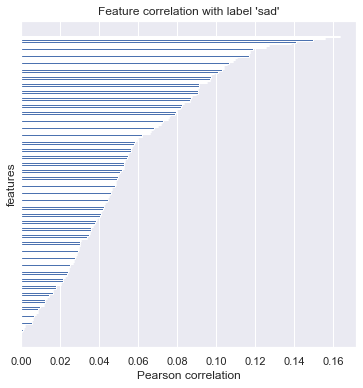

In [34]:
#sad
r_sort = np.abs(r_regression(X, features['sad'])).argsort()
X.columns[r_sort]

# plt.barh(X.columns[r_sort][-10:], r_regression(X, y)[r_sort][-10:])
plt.barh(X.columns[r_sort], np.abs(r_regression(X, features['sad']))[r_sort])

plt.yticks([])
plt.rcParams["figure.figsize"] = (5,5)
plt.title("Feature correlation with label 'sad'")
plt.xlabel("Pearson correlation")
plt.ylabel("features")

Text(0, 0.5, 'features')

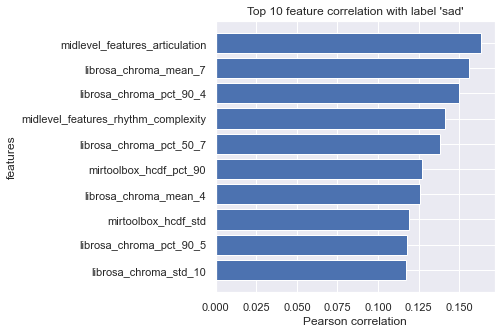

In [35]:
plt.barh(X.columns[r_sort][-10:], np.abs(r_regression(X, features['sad']))[r_sort][-10:])

plt.rcParams["figure.figsize"] = (5,5)
plt.title("Top 10 feature correlation with label 'sad'")
plt.xlabel("Pearson correlation")
plt.ylabel("features")

C:\Users\hause\AppData\Local\Temp\ipykernel_13848\3249427721.py:8: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.yticks([])


Text(0, 0.5, 'features')

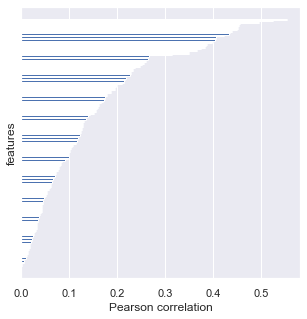

In [36]:
#angry
r_sort = np.abs(r_regression(X, features['angry'])).argsort()
X.columns[r_sort]

# plt.barh(X.columns[r_sort][-10:], r_regression(X, y)[r_sort][-10:])
plt.barh(X.columns[r_sort], np.abs(r_regression(X, features['angry']))[r_sort])

plt.yticks([])
plt.rcParams["figure.figsize"] = (5,5)
plt.xlabel("Pearson correlation")
plt.ylabel("features")

Text(0, 0.5, 'features')

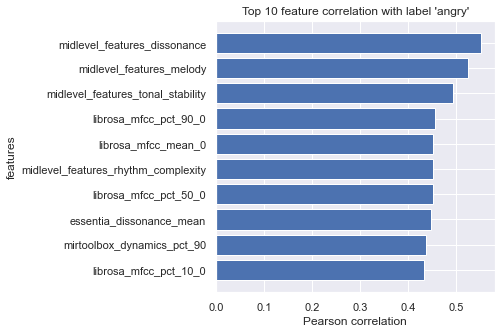

In [37]:
plt.barh(X.columns[r_sort][-10:], np.abs(r_regression(X, features['angry']))[r_sort][-10:])

plt.rcParams["figure.figsize"] = (5,5)
plt.title("Top 10 feature correlation with label 'angry'")
plt.xlabel("Pearson correlation")
plt.ylabel("features")

C:\Users\hause\AppData\Local\Temp\ipykernel_13848\4200269692.py:8: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.yticks([])


Text(0, 0.5, 'features')

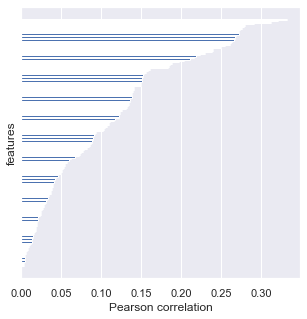

In [38]:
#relaxed
r_sort = np.abs(r_regression(X, features['relaxed'])).argsort()
X.columns[r_sort]

# plt.barh(X.columns[r_sort][-10:], r_regression(X, y)[r_sort][-10:])
plt.barh(X.columns[r_sort], np.abs(r_regression(X, features['relaxed']))[r_sort])

plt.yticks([])
plt.rcParams["figure.figsize"] = (5,5)
plt.xlabel("Pearson correlation")
plt.ylabel("features")

Text(0, 0.5, 'features')

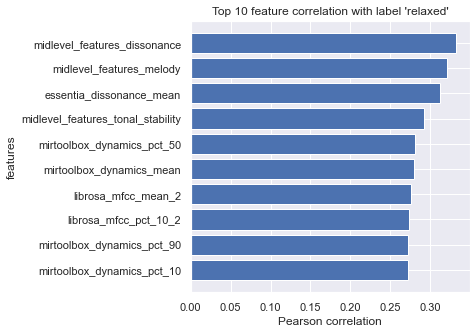

In [39]:
plt.barh(X.columns[r_sort][-10:], np.abs(r_regression(X, features['relaxed']))[r_sort][-10:])

plt.rcParams["figure.figsize"] = (5,5)
plt.title("Top 10 feature correlation with label 'relaxed'")
plt.xlabel("Pearson correlation")
plt.ylabel("features")

C:\Users\hause\AppData\Local\Temp\ipykernel_13848\987135307.py:8: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.yticks([])


Text(0, 0.5, 'features')

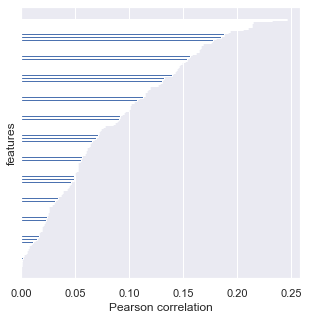

In [40]:
#happy
r_sort = np.abs(r_regression(X, features['happy'])).argsort()
X.columns[r_sort]

# plt.barh(X.columns[r_sort][-10:], r_regression(X, y)[r_sort][-10:])
plt.barh(X.columns[r_sort], np.abs(r_regression(X, features['happy']))[r_sort])

plt.yticks([])
plt.rcParams["figure.figsize"] = (5,5)
plt.xlabel("Pearson correlation")
plt.ylabel("features")

Text(0, 0.5, 'features')

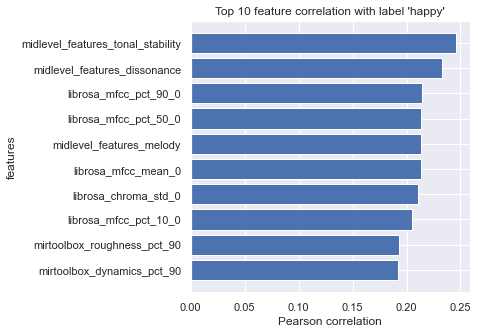

In [41]:
plt.barh(X.columns[r_sort][-10:], np.abs(r_regression(X, features['happy']))[r_sort][-10:])

plt.rcParams["figure.figsize"] = (5,5)
plt.title("Top 10 feature correlation with label 'happy'")
plt.xlabel("Pearson correlation")
plt.ylabel("features")

Most features have a weak correlation below +- 0.3. Only a few features have a medium correlation between +-0.3 and +-0.5